### 0. Library Imports
Load the core Python libraries used throughout the notebook:

* **pandas** – tabular data manipulation  
* **numpy** – numerical computing helpers  
* **seaborn** and **matplotlib.pyplot** – quick exploratory visualisations  

These four are the “bread‑and‑butter” stack for almost any Kaggle project.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### 1. Read & Combine Raw Data
1. Load the **training** (`train.csv`) and **test** (`test.csv`) files provided by Kaggle.  
2. The test set naturally lacks the target column (`SalePrice`), so we add a dummy version filled with `0` so both dataframes share identical schemas.  
3. Vertically concatenate them into a single DataFrame (`df`) so that every subsequent preprocessing step is learned on **all** available rows and can later be cleanly reversed for submission.  
4. Promote the `Id` column to the index to preserve it as a unique identifier while keeping it out of the feature matrix.

In [2]:
# Read the training dataset from CSV file
df_1=pd.read_csv('./train.csv')

# Read the same training dataset again (likely intended to be test data)
df_2=pd.read_csv('./test.csv')

# Check if 'SalePrice' column exists in df_2, if not, add it with default value 0
# This is typically done when working with test data that doesn't have target variable
if 'SalePrice' not in df_2.columns:
    df_2['SalePrice'] = 0

# Concatenate both dataframes vertically (stack them on top of each other)
# axis=0 means concatenate along rows (add more rows)
df = pd.concat([df_1, df_2], axis = 0)
# Set 'Id' column as the index of the combined dataframe
# This removes 'Id' from regular columns and makes it the row identifier
df = df.set_index('Id')

### 2. Quick Peek at the Data
`df.head()` prints the first five records. This gut‑check confirms that the concat worked and that the new index displays the Id values.

In [3]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 3. Dataset Summary
`df.info()` lists column data types and non‑null counts—great for spotting integer columns incorrectly typed as `object` and gauging overall completeness.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

### 4. Missing‑Value Audit (Raw Counts)
Produce a Series of *absolute* missing‑value counts for every column. These raw numbers guide later decisions—e.g., **drop** versus **impute**.

In [5]:
# Get count of missing values for each column
df.isna().sum()

MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

### 5. Identify Columns with *Any* Missing Values
Create a Boolean mask (`columns_with_nulls`) that flags columns containing at least one `NaN`. The mask streamlines subsequent filtering statements.

In [6]:
# Create a boolean mask showing which columns have missing values
columns_with_nulls = df.isnull().sum() > 0
print("Columns with missing values:")
print(columns_with_nulls[columns_with_nulls])

Columns with missing values:
MSZoning        True
LotFrontage     True
Alley           True
Utilities       True
Exterior1st     True
Exterior2nd     True
MasVnrType      True
MasVnrArea      True
BsmtQual        True
BsmtCond        True
BsmtExposure    True
BsmtFinType1    True
BsmtFinSF1      True
BsmtFinType2    True
BsmtFinSF2      True
BsmtUnfSF       True
TotalBsmtSF     True
Electrical      True
BsmtFullBath    True
BsmtHalfBath    True
KitchenQual     True
Functional      True
FireplaceQu     True
GarageType      True
GarageYrBlt     True
GarageFinish    True
GarageCars      True
GarageArea      True
GarageQual      True
GarageCond      True
PoolQC          True
Fence           True
MiscFeature     True
SaleType        True
dtype: bool


### 6. Display Missing Counts for Only the Affected Columns
Show the exact null counts for each problematic column so you can eyeball sensible thresholds (for example, ‘drop if > 50 % missing’).

In [7]:
# Display the count of missing values for columns identified as having nulls
df.isnull().sum()[columns_with_nulls]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

### 7. Isolate Columns that Contain Nulls *(Exploration Helper)*
`df_null` keeps only the columns that have missing data—makes visualisations and manual inspection faster.

In [8]:
df_null  = df[df.isna().sum()[columns_with_nulls].index]

### 8. Preview Null‑Containing Columns
A quick `head()` call to eyeball the subset before plotting any heatmaps.

In [9]:
df_null.head()

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,65.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,...,2003.0,RFn,2.0,548.0,TA,TA,NaN,NaN,NaN,WD
2,RL,80.0,NaN,AllPub,MetalSd,MetalSd,NaN,0.0,Gd,TA,...,1976.0,RFn,2.0,460.0,TA,TA,NaN,NaN,NaN,WD
3,RL,68.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,...,2001.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN,WD
4,RL,60.0,NaN,AllPub,Wd Sdng,Wd Shng,NaN,0.0,TA,Gd,...,1998.0,Unf,3.0,642.0,TA,TA,NaN,NaN,NaN,WD
5,RL,84.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,...,2000.0,RFn,3.0,836.0,TA,TA,NaN,NaN,NaN,WD


### 9. Visualise the Missing‑Data Pattern
A Seaborn heatmap (`True` = bright square) quickly shows whether nulls cluster together or are randomly scattered—useful for deciding between simple and model‑based imputations.

<Axes: ylabel='Id'>

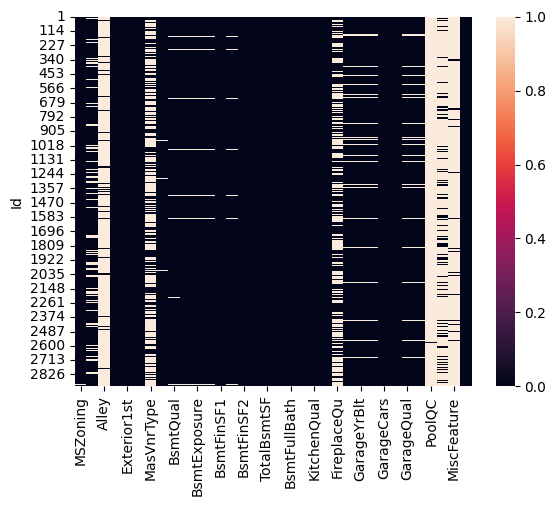

In [10]:
sns.heatmap(df_null.isnull())

### 10. Isolate Categorical Features
Extract all `object`‑dtype columns into `df_objects`; these need different cleaning (fill with mode / one‑hot encode) compared with numeric columns.

In [11]:
df_objects =  df[df.select_dtypes(include=['object']).columns]

### 11. Drop Extremely Sparse Categorical Features
Remove object columns with > 1 100 nulls (well over half the training rows). Keeping such sparse columns usually hurts more than helps.

In [12]:
df = df.drop(df[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)

### 12. Clean & One‑Hot Encode Remaining Categorical Features
1. Further drop categorical columns still holding > 1100 nulls.  
2. Fill remaining nulls with the literal string `'null'` so they survive one‑hot encoding.  
3. Convert every categorical variable into a set of binary dummy variables via `pd.get_dummies`, yielding `df_objects_encoded`.

In [13]:
df_objects = df_objects.drop(df_objects[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis = 1)

df_objects = df_objects.fillna('null')

df_objects_encoded = pd.get_dummies(df_objects)

### 13. Cardinality Spot‑Check
Inspect the distribution of a representative feature (`Utilities`) to ensure categories look reasonable before/after encoding.

In [14]:
df_objects['Utilities'].value_counts()

Utilities
AllPub    2916
null         2
NoSeWa       1
Name: count, dtype: int64

### 14. Sanity Check Encoded Matrix
View the first few rows of the dummy‑variable matrix to verify column naming conventions and overall shape.

In [15]:
df_objects_encoded.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_null,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_null,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
2,False,False,False,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
3,False,False,False,True,False,False,False,True,True,False,...,False,False,True,False,False,False,False,False,True,False
4,False,False,False,True,False,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
5,False,False,False,True,False,False,False,True,True,False,...,False,False,True,False,False,False,False,False,True,False


### 15. Remove Dummy Columns Representing the Placeholder `'null'`
For each one‑hot column containing `'null'`, drop it. This treats missingness implicitly (all zeros) instead of carrying an explicit *Missing* flag that could mislead the model.

In [16]:
for i in df_objects_encoded.columns:
    if 'null' in i:
        df_objects_encoded=df_objects_encoded.drop(i,axis=1)
        print(i)

MSZoning_null
Utilities_null
Exterior1st_null
Exterior2nd_null
BsmtQual_null
BsmtCond_null
BsmtExposure_null
BsmtFinType1_null
BsmtFinType2_null
Electrical_null
KitchenQual_null
Functional_null
GarageType_null
GarageFinish_null
GarageQual_null
GarageCond_null
SaleType_null


### 16. Merge Encoded & Numeric Features, Then Inspect
Concatenate the cleaned numeric subset (`df`) with the encoded categoricals (`df_objects_encoded`) to form `new_df`.  
`new_df.info()` confirms data types, memory usage, and any remaining nulls.

In [17]:
new_df=pd.concat([df,df_objects_encoded], axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Columns: 304 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(230), float64(11), int64(26), object(37)
memory usage: 2.3+ MB


### 17. Column Count After Merge
Print `len(new_df.columns)` to see how many total features you now have—including every dummy variable.

In [18]:
len(new_df.columns)

304

### 18. Sanity Check: Original vs Encoded Feature Counts
Display the counts of numeric columns vs dummy columns separately—helps visualise the dimensionality explosion caused by one‑hot encoding.

In [19]:
len(df.columns), len(df_objects_encoded.columns)

(74, 230)

### 19. Final Removal of Raw Categorical Columns
Drop any residual `object`‑dtype columns from `new_df` (they are now redundantly represented by dummies). Then list any columns still harbouring nulls so you can finish the cleaning.

In [20]:
new_df=new_df.drop(df.select_dtypes(include=['object']),axis=1)
new_df.isna().sum()[new_df.isna().sum()>0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

### 20. Define Imputation Strategy Lists
Hand‑craft two lists:  
* `Mode_columns` – categorical‑in‑spirit numeric features best filled with their most frequent value.  
* `Mean_columns` – continuous numeric features where the arithmetic mean is a sensible substitute.

In [21]:
Mode_columns = ['GarageCars', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath']
Mean_columns = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                'TotalBsmtSF', 'GarageArea']


### 21. Apply Imputation Rules
Loop over `Mode_columns` and `Mean_columns`, filling missing values with each column’s mode or mean respectively. This results in a 100 % complete numeric feature matrix ready for modelling.

In [22]:
for i in Mode_columns:
    new_df[i] = new_df[i].fillna(new_df[i].mode()[0])

for i in Mean_columns:
    new_df[i] = new_df[i].fillna(np.round(new_df[i].mean()))

new_df.isna().sum()[new_df.isna().sum() > 0] 

Series([], dtype: int64)

### 22. Re‑split Combined Data Back to Train & Test
After all preprocessing is finished, slice `new_df` back into its original pieces:  
* **`training_data`** – rows that came from `train.csv` (they still contain the true `SalePrice` labels)  
* **`testing_data`** – rows that originated from `test.csv` (labels are dummy zeros)  

These frames are now ready for model training and Kaggle submission.

In [23]:
# Splitting back the training data and the testing data

training_data=new_df[0:len(df_1)]
testing_data=new_df[len(df_1):]

# Removing the SalePrice column from the testing data
testing_data=testing_data.drop(columns='SalePrice')